--> Đang tải dữ liệu...


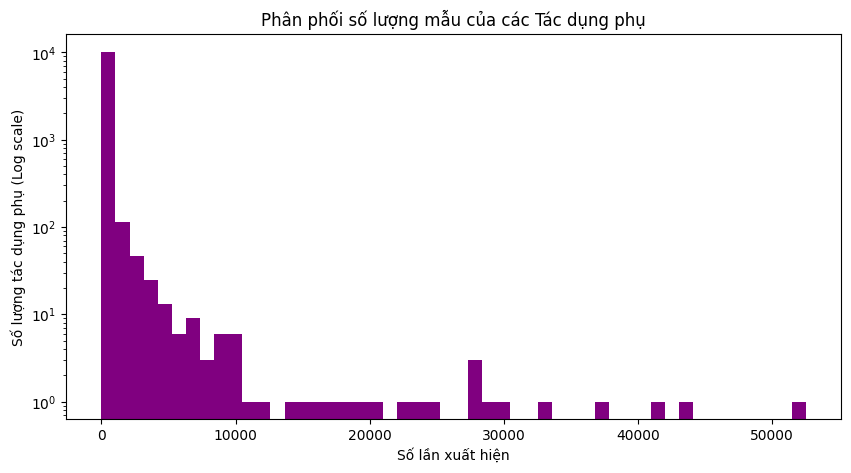

Tổng số loại tác dụng phụ (Cột Y): 10488
Số loại xuất hiện < 10 lần: 6571
Số loại xuất hiện < 100 lần: 9282

--> Đang lọc lấy 100 tác dụng phụ phổ biến nhất...
   + Kích thước Y mới: (661284, 100)


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

# CẤU HÌNH ĐƯỜNG DẪN
DATA_FOLDER = r"C:\Users\dotie\Downloads\medi_data\processed_data"
X_PATH = os.path.join(DATA_FOLDER, "X_data.npz")
Y_PATH = os.path.join(DATA_FOLDER, "Y_data.npz")

print("--> Đang tải dữ liệu...")
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# --- 1. Phân tích tần suất xuất hiện của các tác dụng phụ ---
# Tính tổng số ca dương tính cho mỗi cột (mỗi loại tác dụng phụ)
y_counts = np.array(Y.sum(axis=0)).flatten()

# Vẽ biểu đồ phân phối
plt.figure(figsize=(10, 5))
plt.hist(y_counts, bins=50, log=True, color='purple')
plt.title("Phân phối số lượng mẫu của các Tác dụng phụ")
plt.xlabel("Số lần xuất hiện")
plt.ylabel("Số lượng tác dụng phụ (Log scale)")
plt.show()

print(f"Tổng số loại tác dụng phụ (Cột Y): {len(y_counts)}")
print(f"Số loại xuất hiện < 10 lần: {sum(y_counts < 10)}")
print(f"Số loại xuất hiện < 100 lần: {sum(y_counts < 100)}")

# --- 2. Lọc lấy Top K tác dụng phụ phổ biến nhất ---
TOP_K = 100 # Chỉ dự đoán 100 tác dụng phụ phổ biến nhất để mô hình học tốt
# Lấy index của các cột có số lượng mẫu cao nhất
top_k_indices = np.argsort(y_counts)[-TOP_K:] 

print(f"\n--> Đang lọc lấy {TOP_K} tác dụng phụ phổ biến nhất...")
Y_filtered = Y[:, top_k_indices] # Cắt ma trận Y, chỉ giữ lại cột quan trọng

print(f"   + Kích thước Y mới: {Y_filtered.shape}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

# 1. Chia Train/Test trên dữ liệu đã lọc
# Lưu ý: Với Multilabel, ta không dùng stratify đơn giản được, nên random_state quan trọng
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_filtered, test_size=0.2, random_state=42
)

# 2. Dataset Class
class MultilabelDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        # y bây giờ là ma trận nhiều cột (không phải 1 cột như Goal 1)
        self.y = y 
        
    def __len__(self): 
        return self.X.shape[0]
    
    def __getitem__(self, i):
        # Chuyển X sang dense, Y giữ nguyên (vì Y đã lọc nhỏ lại rồi)
        x_tensor = torch.tensor(self.X[i].toarray(), dtype=torch.float32).squeeze()
        y_tensor = torch.tensor(self.y[i].toarray(), dtype=torch.float32).squeeze()
        return x_tensor, y_tensor

# DataLoader
train_dl = DataLoader(MultilabelDS(X_train, y_train), batch_size=128, shuffle=True)
test_dl = DataLoader(MultilabelDS(X_test, y_test), batch_size=128, shuffle=False)

# 3. Kiến trúc mạng (Thay đổi Output Layer)
class SideEffectProbModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SideEffectProbModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024), # Giúp ổn định training
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Output layer: Số lượng nơ-ron = Số lượng tác dụng phụ (TOP_K)
            nn.Linear(512, output_dim) 
        )
        
    def forward(self, x):
        return self.net(x) # Trả về logits

# 4. Thiết lập
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SideEffectProbModel(X.shape[1], TOP_K).to(device)

# Loss Function cho Multilabel: BCEWithLogitsLoss
# Nó tính lỗi cho từng nhãn một cách độc lập
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training
print(f"\n--> Bắt đầu train Multilabel Model trên {device}...")
model.train()
for epoch in range(10): # Tăng epoch lên vì bài toán khó hơn
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")

print("Huấn luyện hoàn tất!")


--> Bắt đầu train Multilabel Model trên cpu...
Epoch 1 Loss: 0.0652
Epoch 2 Loss: 0.0619
Epoch 3 Loss: 0.0612
Epoch 4 Loss: 0.0607
Epoch 5 Loss: 0.0603
Epoch 6 Loss: 0.0600
Epoch 7 Loss: 0.0597
Epoch 8 Loss: 0.0594
Epoch 9 Loss: 0.0592
Epoch 10 Loss: 0.0590
Huấn luyện hoàn tất!


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torch

def evaluate_at_threshold(model, dataloader, threshold=0.1):
    """
    Hàm đánh giá mô hình tại một ngưỡng (threshold) cụ thể.
    """
    model.eval()
    y_true_list = []
    y_prob_list = []

    print(f"--> Đang tính toán với Threshold = {threshold}...")
    
    # 1. Dự đoán xác suất
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            # Tính xác suất
            logits = model(xb)
            probs = torch.sigmoid(logits)
            
            y_prob_list.append(probs.cpu().numpy())
            y_true_list.append(yb.numpy())

    # 2. Gộp thành ma trận lớn
    y_prob = np.vstack(y_prob_list)
    y_true = np.vstack(y_true_list)

    # 3. Áp dụng ngưỡng để ra nhãn 0/1
    # Nếu xác suất > threshold thì coi là 1 (Có bệnh)
    y_pred = (y_prob > threshold).astype(int)

    # 4. Tính toán các chỉ số (Micro Average)
    precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

    # 5. In kết quả theo format bạn muốn
    print("-" * 30)
    print(f"Threshold = {threshold}")
    print(f"Micro Precision: {precision:.4f}")
    print(f"Micro Recall:    {recall:.4f}")
    print(f"Micro F1 Score:  {f1:.4f}")
    print("-" * 30)
    
    return precision, recall, f1

# --- CHẠY THỬ NGHIỆM ---

# 1. Thử với Threshold = 0.1 (như bạn yêu cầu)
evaluate_at_threshold(model, test_dl, threshold=0.1)

# 2. Thử với Threshold = 0.5 (Mặc định)
evaluate_at_threshold(model, test_dl, threshold=0.5)

# 3. Thử với Threshold cực thấp (0.01) để xem Recall có tăng không
evaluate_at_threshold(model, test_dl, threshold=0.01)

--> Đang tính toán với Threshold = 0.1...
------------------------------
Threshold = 0.1
Micro Precision: 0.1552
Micro Recall:    0.3338
Micro F1 Score:  0.2119
------------------------------
--> Đang tính toán với Threshold = 0.5...
------------------------------
Threshold = 0.5
Micro Precision: 0.6065
Micro Recall:    0.0194
Micro F1 Score:  0.0376
------------------------------
--> Đang tính toán với Threshold = 0.01...
------------------------------
Threshold = 0.01
Micro Precision: 0.0364
Micro Recall:    0.8895
Micro F1 Score:  0.0699
------------------------------


(0.03637825079280996, 0.8894674919433219, 0.06989775942230093)